In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import string
from ggplot import *
from sklearn.manifold import TSNE

In [242]:
def clean_wellness():
    df = pd.read_csv('./data/wellness.csv')

    df = df[['Date', 'PlayerID', 'Fatigue', 'Soreness', 'Desire', 'Irritability','SleepHours', 'SleepQuality', 'Pain', 'Illness', 'Menstruation']]

    df.loc[df['Pain'] == 'Yes', 'Pain'] = 1
    df.loc[df['Pain'] == 'No', 'Pain'] = 0

    df.loc[df['Illness'] == 'Slightly Off', 'Illness'] = 1
    df.loc[df['Illness'] == 'No', 'Illness'] = 0

    df.loc[df['Menstruation'] == 'Yes', 'Menstruation'] = 1
    df.loc[df['Menstruation'] == 'No', 'Menstruation'] = 0


    nRows, nCols = df.shape
    print(nRows,"rows")
    print(nCols,"columns")

    col = ['Fatigue','Soreness','Desire','Irritability','SleepQuality']
    ID_num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

    df1=df

    from sklearn import preprocessing
    for num in ID_num:
        df1.loc[df1['PlayerID'] == num,'Fatigue']  = 100*preprocessing.normalize([df1.loc[df1['PlayerID'] == num]['Fatigue']])[0]

    for num in ID_num:
        df1.loc[df1['PlayerID'] == num,'Soreness']  = 100*preprocessing.normalize([df1.loc[df1['PlayerID'] == num]['Soreness']])[0]
    for num in ID_num:
        df1.loc[df1['PlayerID'] == num,'Desire']  = 100*preprocessing.normalize([df1.loc[df1['PlayerID'] == num]['Desire']])[0]

    for num in ID_num:
        df1.loc[df1['PlayerID'] == num,'Irritability']  = 100*preprocessing.normalize([df1.loc[df1['PlayerID'] == num]['Irritability']])[0]
    for num in ID_num:
        df1.loc[df1['PlayerID'] == num,'SleepQuality']  = 100*preprocessing.normalize([df1.loc[df1['PlayerID'] == num]['SleepQuality']])[0]
    
    df1.update(df1.Menstruation.fillna(df1.Menstruation.mean()).astype(int))
    df1.Menstruation = df1.Menstruation.astype(int)
    
    df1.update(df1.Illness.replace('Yes',1).astype(int))
    df1.Illness = df1.Illness.astype(int)

    
    return df1

In [243]:
wellness = clean_wellness()

5011 rows
11 columns


In [245]:
games = pd.read_csv('./data./games.csv')
game_date = games[['GameID','Date']]

In [249]:
game_days = set(games.Date)

In [250]:
gps_df = pd.read_csv('./data/gps.csv')

In [533]:
def dps_performance(df):

#     from sklearn import preprocessing

#     player_num = df['PlayerID'].unique()
#     for num in player_num:
#         df.loc[df['PlayerID'] == num,'Speed']  = 100*preprocessing.normalize([df.loc[df['PlayerID'] == num]['Speed']])[0]
#         df.loc[df['PlayerID'] == num,'AccelImpulse']  = 100*preprocessing.normalize([df.loc[df['PlayerID'] == num]['AccelImpulse']])[0]
#         df.loc[df['PlayerID'] == num,'AccelLoad']  = 100*preprocessing.normalize([df.loc[df['PlayerID'] == num]['AccelLoad']])[0]
    
#     df['Performance'] = df['Speed']

    speed = df.groupby(['PlayerID', 'GameID'])['Speed'].mean()
    speed  = pd.DataFrame(data=speed).reset_index()
    
#     percent_first = np.percentile(performance['Performance'],33)
#     percent_second = np.percentile(performance['Performance'],67)
    percent_half = np.median(speed['Speed'])
    print(percent_half)
    
    speed['catagory'] = 'low'
    speed.loc[speed['Speed']>percent_half,'catagory'] = 'high'
#     performance.loc[performance['Performance']>percent_second,'catagory'] = 'high'
    return speed

In [534]:
performance = dps_performance(gps_df)
# performance = performance[['GameID','PlayerID','Performance','catagory']]
performance.columns = ['PlayerID','GameID','Performance','catagory']

0.11131903534771796


In [535]:
performance.catagory.value_counts()

low     225
high    223
Name: catagory, dtype: int64

### get feature from rpe 

In [555]:
def clean_rpe():
    
    pre = pd.read_csv('./data/rpe.csv',na_values=['None'])
    df = pre
    print('df shape is ', df.shape)
        # traing 
    df.Training = df.Training.replace('Yes', 1)
    df.Training = df.Training.replace('No', 0)
    
    # dummies for SessionType
    dummies= pd.get_dummies(df.SessionType, prefix='SessionType' )
    for col in list((dummies)):
        df.insert(4, col, dummies[col] )
    
    # for numeric cols, replace nan with mean for each player
    numeric_cols = [
        'Duration',
        'RPE',
        'SessionLoad',
        'DailyLoad',
        'AcuteLoad',
        'ChronicLoad',
        'AcuteChronicRatio',
        'ObjectiveRating',
        'FocusRating']
    
    for col in numeric_cols:
        for player in set(df.PlayerID):
            mean_ = (df[df.PlayerID == player][col].mean())
            df.update( df[df.PlayerID == player][col].fillna(mean_)) 
#             df[df.PlayerID == player][col] = df[df.PlayerID == player][col].replace(np.nan, mean_)
    
    
    # dummies for BestOutOfMyself
    dummies= pd.get_dummies(df.BestOutOfMyself, prefix='BestOutOfMyself' )
    for col in list((dummies)):
        df.insert(21, col, dummies[col] )

    df = df.drop(columns = ['SessionType','BestOutOfMyself'])
    df.head()
    return df

In [564]:
rpe = pd.read_csv('./data/rpe.csv',na_values=['None'])

In [565]:
rpe[rpe.DailyLoad.notnull()][rpe.Date == day]

C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
5582,2017-11-30,1,Yes,Conditioning,60.0,4.0,240.0,1150.0,376.4,333.04,1.13,NaN,NaN,Absolutely
5585,2017-11-30,2,Yes,Game,26.0,6.0,156.0,186.0,208.0,372.18,0.56,NaN,NaN,NaN
5587,2017-11-30,3,Yes,Game,40.0,8.0,320.0,1030.0,407.9,494.64,0.82,8.0,8.0,Absolutely
5591,2017-11-30,3,No,Conditioning,30.0,5.0,150.0,150.0,260.7,457.86,0.57,8.0,8.0,Absolutely
5592,2017-11-30,4,Yes,Game,32.0,5.0,160.0,632.0,236.0,381.14,0.62,7.0,7.0,NaN
5595,2017-11-30,6,Yes,Game,27.0,9.0,243.0,731.0,297.3,387.71,0.77,7.0,10.0,Absolutely
5598,2017-11-30,7,Yes,Game,39.0,8.0,312.0,824.0,274.1,495.14,0.55,8.0,9.0,NaN
5600,2017-11-30,8,Yes,Game,40.0,7.0,280.0,838.0,256.9,462.07,0.56,NaN,NaN,NaN
5603,2017-11-30,9,Yes,Skills,75.0,5.0,375.0,529.0,218.4,373.36,0.58,9.0,9.0,Absolutely
5607,2017-11-30,11,Yes,Game,34.0,7.0,238.0,788.0,407.6,513.32,0.79,8.0,10.0,Absolutely


In [558]:
# performance = df.groupby(['PlayerID', 'GameID'])['Performance'].mean()
# performance  = pd.DataFrame(data=performance).reset_index()

### Construct model df 

In [576]:
a = rpe[rpe.DailyLoad.notnull()][['Date','PlayerID']]

In [598]:
from datetime import date
from datetime import datetime,timedelta

In [594]:
a = '2018-07-21'

In [608]:
day ='2018-07-20'

In [607]:
(datetime.strptime(day, "%Y-%m-%d") - timedelta(1)).strftime("%Y-%m-%d")

'2017-11-29'

In [615]:
rpe[rpe.DailyLoad.notnull()][rpe.Date == day_minus]

C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
3,2018-07-20,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
6,2018-07-20,13,Yes,Game,27.0,6.0,162.0,306.0,259.4,287.32,0.90,NaN,NaN,Not at all


In [590]:
a['Date'] = pd.to_datetime(a['Date']) - pd.to_timedelta(a['day'], unit='d')

In [616]:
model_df = pd.DataFrame()
for g_id in range(38):
    day = game_date.loc[game_date['GameID']== g_id+1].values[0][1]  # game date

    # get performance metric from gps_df
    # they are from people who actually in the game
    true_label = performance[performance['GameID']==g_id]['catagory']
    
    # merge to get model df
    merged_df = performance[performance['GameID']==g_id].merge(
        wellness[wellness.Date == day].drop(columns = ['Date']),
        left_on=['PlayerID'], right_on=['PlayerID'],suffixes=('_left', '_right'))
    
    day_minus = (datetime.strptime(day, "%Y-%m-%d") - timedelta(1)).strftime("%Y-%m-%d")
    merged_df = merged_df.merge(
        rpe[rpe.DailyLoad.notnull()][rpe.Date == day_minus][['AcuteChronicRatio','PlayerID']],
        left_on=['PlayerID'], right_on=['PlayerID'],suffixes=('_left', '_right'))
    
    
    model_df = model_df.append(merged_df, ignore_index = True, sort=False) # append new ones. 
model_matrix = model_df.values

C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFra

In [617]:
model_df

,GameID,Performance,catagory,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,AcuteChronicRatio,PlayerID
0,1,0.069078,low,5.531599,6.223467,6.456587,5.145998,8.75,6.309431,0,0,0,0.50,2
1,1,0.129744,high,7.863541,6.605482,9.116057,5.384307,8.00,5.458494,0,0,0,0.52,3
2,1,0.188641,high,6.561787,7.025116,6.207709,6.222714,9.25,6.062694,0,0,0,0.48,6
3,1,0.118115,high,8.561092,6.827887,8.428995,5.780130,9.00,5.493386,0,0,0,0.32,7
4,1,0.094612,low,7.382537,9.274778,9.947357,6.217540,6.25,4.084753,0,0,0,0.29,8
5,1,0.155739,high,5.353836,5.660818,5.337605,5.328126,9.50,5.302317,0,0,0,0.40,9
6,1,0.148709,high,7.108935,7.035975,5.718372,5.676758,9.25,7.071068,1,0,0,0.30,10
7,1,0.095525,low,7.817631,7.712299,10.845221,5.857702,8.25,6.474391,0,0,0,0.56,11
8,1,0.163540,high,8.567373,8.434690,8.159528,8.200028,7.50,7.186531,0,0,0,0.27,12
9,1,0.068145,low,6.041221,7.021868,8.022136,5.324349,9.25,5.439786,0,0,0,0.56,13


In [367]:
model_df['Moni'] = model_df['Fatigue']+model_df['Soreness']+model_df['Desire']+model_df['Irritability']+model_df['SleepQuality']

In [394]:
# model_df = model_df.drop(columns = ['Fatigue','Soreness','Desire','Irritability','SleepQuality'])
# model_df

In [407]:
# model_df.info()

### correlation 

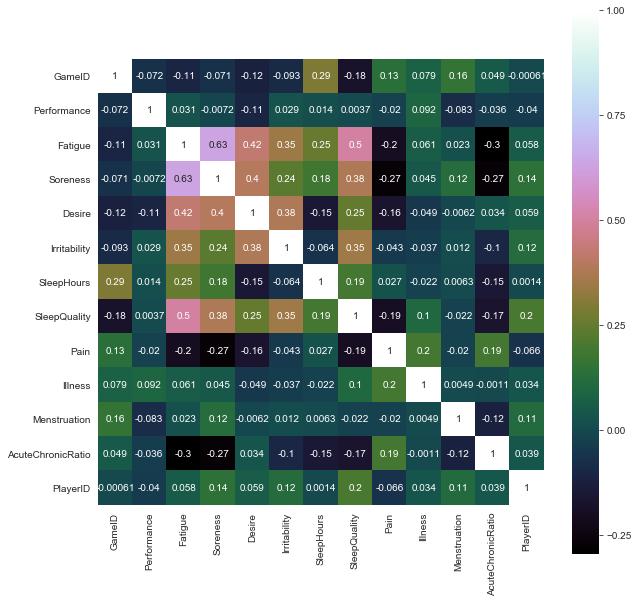

In [618]:
correlation = model_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### PCA for visualization 

In [648]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(model_df.drop(columns = ['catagory']).values)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

# finalDf = pd.concat([principalDf, model_df[['catagory']]], axis = 1)


In [649]:
# finalDf.update(finalDf['Speed'].astype('category'))

In [650]:
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# targets = finalDf['catagory'].unique().tolist()

# for target in zip(targets):
#     indicesToKeep = finalDf['catagory'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , s = 50)
# ax.legend(targets)
# ax.grid()

In [651]:
# pca.explained_variance_ratio_


# PCA for speeding up training 

#### split data 

In [690]:
df = model_df.drop(columns = ['GameID','Performance','Pain','Illness','Menstruation','SleepHours',])
df.head()

,catagory,Fatigue,Soreness,Desire,Irritability,SleepQuality,AcuteChronicRatio,PlayerID
0,low,5.531599,6.223467,6.456587,5.145998,6.309431,0.50,2
1,high,7.863541,6.605482,9.116057,5.384307,5.458494,0.52,3
2,high,6.561787,7.025116,6.207709,6.222714,6.062694,0.48,6
3,high,8.561092,6.827887,8.428995,5.780130,5.493386,0.32,7
4,low,7.382537,9.274778,9.947357,6.217540,4.084753,0.29,8


In [696]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    df.drop(columns = ['catagory','PlayerID']), df.catagory, test_size=0.3, random_state=42)

#### standardize 

In [697]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_X)
# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

#### PCA to reduce dimension 

In [550]:
# from sklearn.decomposition import PCA
# # Make an instance of the Model
# pca = PCA(.95)
# pca.fit(train_X)

# train_X = pca.transform(train_X)
# test_X = pca.transform(test_X)


#### train the model: logistic regression CV 

In [698]:
# from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

# clf = LogisticRegressionCV(cv = 10,random_state=0,
#                            multi_class='auto')
#                            #solver = 'lbfgs')
# clf.fit(train_X, train_y)
# clf.predict(test_X)

# clf.predict_proba(test_X).shape

# clf.score(test_X, test_y) 


0.4536082474226804

#### train the model: random forest 

In [704]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(train_X, train_y)

dt_predictions = dt_classifier.predict(test_X)


from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=1000)

rf_classifier.fit(train_X, train_y)

rf_predictions = rf_classifier.predict(test_X)

# np.sum(rf_predictions != test_y)/test_y.shape[0] # 38.9% error
print("Error rate is {} ".format(np.sum(rf_predictions != test_y)/test_y.shape[0]))

Error rate is 0.29896907216494845 


In [666]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(train_X, train_y)
clf.score(test_X,test_y)

0.5773195876288659

In [514]:
def tsne(df):

    # df
    # run tsne
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
    tsne_results = tsne.fit_transform(df.drop(columns=['catagory','PlayerID']).values)
    # plot 
    df_tsne = df.copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]
    

    # color by sequences
    chart1 = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='catagory') ) \
            + geom_point(size=75,alpha=0.8) \
            + ggtitle("tSNE dimensions colored by PlayerID")
#     # color by label
#     chart2 = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='PlayerID') ) \
#             + geom_point(size=75,alpha=0.8) \
#             + ggtitle("tSNE dimensions colored by LABEL")
    return chart1

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 322 samples in 0.001s...
[t-SNE] Computed neighbors for 322 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 322 / 322
[t-SNE] Mean sigma: 1.312467


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.115490
[t-SNE] KL divergence after 300 iterations: 0.493951


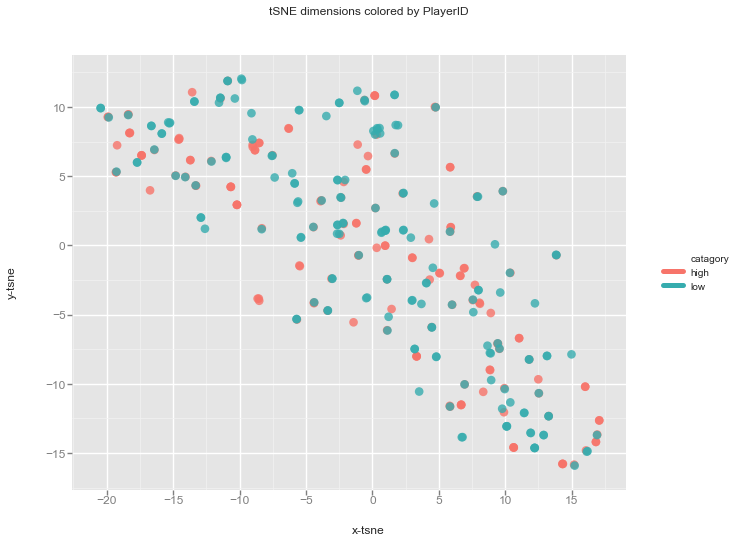

<ggplot: (-9223371901956872588)>

In [705]:
tsne(model_df.drop(columns=['GameID','Performance']))

In [638]:
test_y = test_y.replace('high',1).replace('low',0)
rf_predictions = pd.DataFrame(rf_predictions).replace('high',1).replace('low',0).values

array([0.       , 0.6097561, 1.       ])

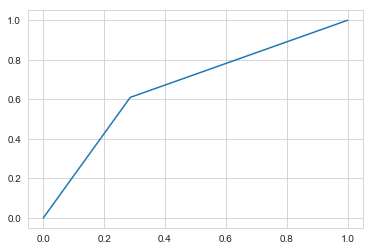

In [646]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_y, rf_predictions)

plt.plot(fpr, tpr)
fpr

tpr

# thresholds

In [633]:
from sklearn.metrics import roc_auc_score

dt_auc = roc_auc_score(test_y, dt_classifier.predict_proba(test_X)[:, 1])

dt_auc

rf_auc = roc_auc_score(test_y, rf_classifier.predict_proba(test_X)[:, 1])

rf_auc

0.6866289198606272

In [516]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, random_state=0).fit(train_X)
# kmeans.labels_
# labels = kmeans.predict(test_X)

# plt.scatter(test_X[:])

# kmeans.cluster_centers_